In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size, neurons, num_layers):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, neurons)
        init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        self.fc2 = nn.Linear(neurons, neurons)
        init.kaiming_uniform_(self.fc2.weight, nonlinearity="relu")
        self.fc3 = nn.Linear(neurons, output_size)
        init.xavier_uniform_(self.fc3.weight)
        self.num_layers = num_layers

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for _ in range(self.num_layers - 1):
            x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
input_size = 28 * 28
output_size = 10
num_neurons = [5, 10, 20, 50, 75, 100]
datasize = [6000, 15000, 30000, 45000, 60000]
num_hidden_layers = [1, 2, 3, 4, 5]

batch_size = 128
num_epochs = 20
learning_rate = 0.01

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
def train(model, num_epochs, dataloader, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in dataloader:
            images = Variable(images.view(images.shape[0], -1)) 
            labels = Variable(labels)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = validate(model, dataloader, criterion)
        
        scheduler.step(val_loss)
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}"
        )

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.inference_mode():
        for images, labels in val_loader:
            images = Variable(images.view(images.shape[0], -1))
            labels = Variable(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in dataloader:
            images = Variable(images.view(images.shape[0], -1))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # compute accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [6]:
train_accuracy1, test_accuracy1 = [], []
for neurons in num_neurons:
    model = DNN(input_size, output_size, neurons, num_layers=1)
    train(model, num_epochs, trainloader, learning_rate)
    train_acc, test_acc = evaluate(model, trainloader), evaluate(model, testloader)
    train_accuracy1.append(train_acc)
    test_accuracy1.append(test_acc)
    print(f'Neurons: {neurons}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')

Epoch [1/20], Loss: 0.6774
Epoch [2/20], Loss: 0.4695
Epoch [3/20], Loss: 0.4160
Epoch [4/20], Loss: 0.3956
Epoch [5/20], Loss: 0.3814
Epoch [6/20], Loss: 0.3747
Epoch [7/20], Loss: 0.3667
Epoch [8/20], Loss: 0.3634
Epoch [9/20], Loss: 0.3576
Epoch [10/20], Loss: 0.3514
Epoch [11/20], Loss: 0.3480
Epoch [12/20], Loss: 0.3473
Epoch [13/20], Loss: 0.3468
Epoch [14/20], Loss: 0.3435
Epoch [15/20], Loss: 0.3417
Epoch [16/20], Loss: 0.3420
Epoch [17/20], Loss: 0.3406
Epoch [18/20], Loss: 0.3403
Epoch [19/20], Loss: 0.3372
Epoch [20/20], Loss: 0.3389
Neurons: 5, Train Accuracy: 91.06, Test Accuracy: 90.55
Epoch [1/20], Loss: 0.4949
Epoch [2/20], Loss: 0.3524
Epoch [3/20], Loss: 0.3352
Epoch [4/20], Loss: 0.3208
Epoch [5/20], Loss: 0.3134
Epoch [6/20], Loss: 0.3074
Epoch [7/20], Loss: 0.3010
Epoch [8/20], Loss: 0.2967
Epoch [9/20], Loss: 0.2952
Epoch [10/20], Loss: 0.2910
Epoch [11/20], Loss: 0.2868
Epoch [12/20], Loss: 0.2856
Epoch [13/20], Loss: 0.2835
Epoch [14/20], Loss: 0.2801
Epoch [15/

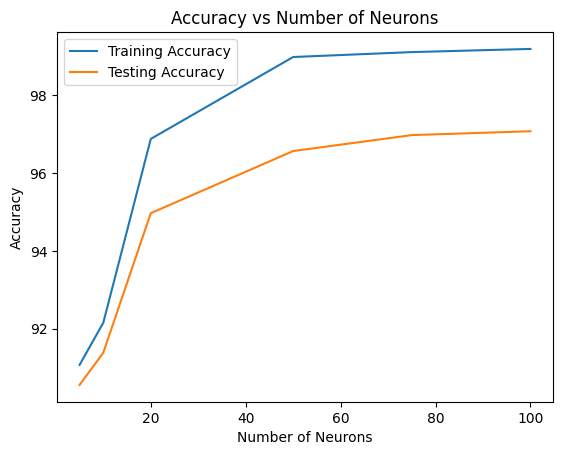

In [7]:
plt.plot(num_neurons, train_accuracy1, label="Training Accuracy")
plt.plot(num_neurons, test_accuracy1, label="Testing Accuracy")
plt.xlabel("Number of Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Neurons")
plt.legend()
plt.show()

In [8]:
train_sub_accuracy2, train_accuracy2, test_accuracy2 = [], [], []
for size in datasize:
    trainset_subset = torch.utils.data.Subset(trainset, range(size))
    trainloader_subset = torch.utils.data.DataLoader(
        trainset_subset, batch_size=batch_size, shuffle=True
    )

    model = DNN(input_size, output_size, 100, num_layers=2)
    train(model, num_epochs, trainloader_subset, learning_rate)
    train_sub_acc, train_acc, test_acc = evaluate(model, trainloader_subset), evaluate(model, trainloader), evaluate(model, testloader)
    train_sub_accuracy2.append(train_sub_acc)
    train_accuracy2.append(train_acc)
    test_accuracy2.append(test_acc)

    print(f'Training Data Fraction: {size}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')

Epoch [1/20], Loss: 0.5524
Epoch [2/20], Loss: 0.1930
Epoch [3/20], Loss: 0.1316
Epoch [4/20], Loss: 0.0928
Epoch [5/20], Loss: 0.0671
Epoch [6/20], Loss: 0.0483
Epoch [7/20], Loss: 0.0476
Epoch [8/20], Loss: 0.0693
Epoch [9/20], Loss: 0.0593
Epoch [10/20], Loss: 0.0279
Epoch [11/20], Loss: 0.0223
Epoch [12/20], Loss: 0.0165
Epoch [13/20], Loss: 0.0207
Epoch [14/20], Loss: 0.0243
Epoch [15/20], Loss: 0.0362
Epoch [16/20], Loss: 0.0456
Epoch [17/20], Loss: 0.0646
Epoch [18/20], Loss: 0.0432
Epoch [19/20], Loss: 0.0225
Epoch [20/20], Loss: 0.0380


Training Data Fraction: 6000, Train Accuracy: 93.89, Test Accuracy: 93.28
Epoch [1/20], Loss: 0.4087
Epoch [2/20], Loss: 0.1684
Epoch [3/20], Loss: 0.1205
Epoch [4/20], Loss: 0.0885
Epoch [5/20], Loss: 0.0718
Epoch [6/20], Loss: 0.0754
Epoch [7/20], Loss: 0.0712
Epoch [8/20], Loss: 0.0807
Epoch [9/20], Loss: 0.0526
Epoch [10/20], Loss: 0.0388
Epoch [11/20], Loss: 0.0399
Epoch [12/20], Loss: 0.0614
Epoch [13/20], Loss: 0.0458
Epoch [14/20], Loss: 0.0539
Epoch [15/20], Loss: 0.0607
Epoch [16/20], Loss: 0.0461
Epoch [17/20], Loss: 0.0496
Epoch [18/20], Loss: 0.0434
Epoch [19/20], Loss: 0.0438
Epoch [20/20], Loss: 0.0423
Training Data Fraction: 15000, Train Accuracy: 96.51, Test Accuracy: 95.85
Epoch [1/20], Loss: 0.3061
Epoch [2/20], Loss: 0.1418
Epoch [3/20], Loss: 0.1096
Epoch [4/20], Loss: 0.0955
Epoch [5/20], Loss: 0.0856
Epoch [6/20], Loss: 0.0758
Epoch [7/20], Loss: 0.0710
Epoch [8/20], Loss: 0.0648
Epoch [9/20], Loss: 0.0664
Epoch [10/20], Loss: 0.0611
Epoch [11/20], Loss: 0.0757
E

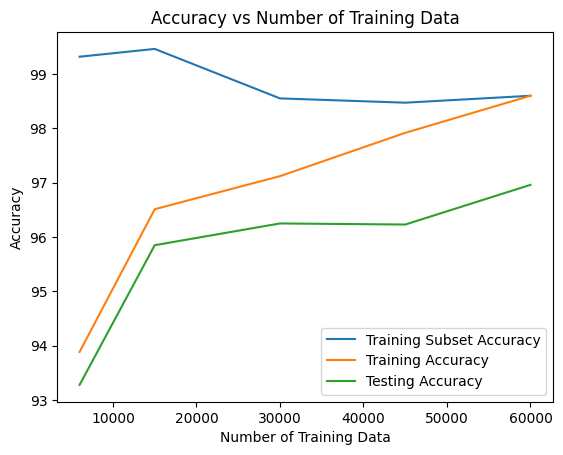

In [9]:
plt.plot(datasize, train_sub_accuracy2, label="Training Subset Accuracy")
plt.plot(datasize, train_accuracy2, label="Training Accuracy")
plt.plot(datasize, test_accuracy2, label="Testing Accuracy")
plt.xlabel("Number of Training Data")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Training Data")
plt.legend()
plt.show()

In [10]:
train_accuracy3, test_accuracy3 = [], []
for i in num_hidden_layers:
    model = DNN(input_size, output_size, 100, num_layers=i)
    train(model, num_epochs, trainloader, learning_rate)
    train_acc, test_acc = evaluate(model, trainloader), evaluate(model, testloader)
    train_accuracy3.append(train_acc)
    test_accuracy3.append(test_acc)
    print(f'Hidden Layers: {i}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')


Epoch [1/20], Loss: 0.2225


Epoch [2/20], Loss: 0.1149
Epoch [3/20], Loss: 0.0870
Epoch [4/20], Loss: 0.0795
Epoch [5/20], Loss: 0.0710
Epoch [6/20], Loss: 0.0667
Epoch [7/20], Loss: 0.0610
Epoch [8/20], Loss: 0.0590
Epoch [9/20], Loss: 0.0539
Epoch [10/20], Loss: 0.0462
Epoch [11/20], Loss: 0.0526
Epoch [12/20], Loss: 0.0450
Epoch [13/20], Loss: 0.0512
Epoch [14/20], Loss: 0.0479
Epoch [15/20], Loss: 0.0440
Epoch [16/20], Loss: 0.0340
Epoch [17/20], Loss: 0.0470
Epoch [18/20], Loss: 0.0474
Epoch [19/20], Loss: 0.0393
Epoch [20/20], Loss: 0.0363
Hidden Layers: 1, Train Accuracy: 99.15, Test Accuracy: 97.02
Epoch [1/20], Loss: 0.2381
Epoch [2/20], Loss: 0.1279
Epoch [3/20], Loss: 0.1116
Epoch [4/20], Loss: 0.0958
Epoch [5/20], Loss: 0.0883
Epoch [6/20], Loss: 0.0823
Epoch [7/20], Loss: 0.0804
Epoch [8/20], Loss: 0.0693
Epoch [9/20], Loss: 0.0706
Epoch [10/20], Loss: 0.0764
Epoch [11/20], Loss: 0.0667
Epoch [12/20], Loss: 0.0602
Epoch [13/20], Loss: 0.0634
Epoch [14/20], Loss: 0.0595
Epoch [15/20], Loss: 0.0557
Epo

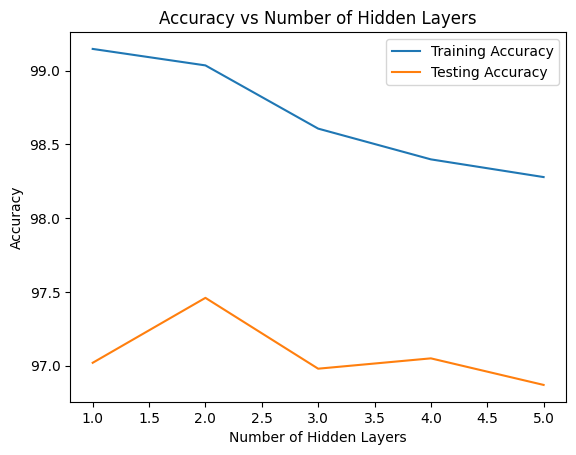

In [11]:
plt.plot(num_hidden_layers, train_accuracy3, label="Training Accuracy")
plt.plot(num_hidden_layers, test_accuracy3, label="Testing Accuracy")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Hidden Layers")
plt.legend()
plt.show()

# **Part II**

In [12]:
class DNNP2(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes):
        super(DNNP2, self).__init__()
        layers = []
        current_input_size = input_size

        for hidden_size in hidden_sizes:
            linear_layer = nn.Linear(current_input_size, hidden_size)
            layers.append(linear_layer)
            layers.append(nn.ReLU())
            current_input_size = hidden_size

        output_layer = nn.Linear(current_input_size, output_size)
        layers.append(output_layer)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [23]:
train_data = pd.read_csv("HW2_training.csv")
test_data = pd.read_csv("HW2_testing.csv")

X_train = torch.tensor(train_data.iloc[:, 1:].values, dtype=torch.float32)
y_train = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)

X_test = torch.tensor(test_data.iloc[:, 1:].values, dtype=torch.float32)
y_test = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [88]:
batch_sizeP2 = 32

train_loader = DataLoader(train_dataset, batch_size=batch_sizeP2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_sizeP2 = len(train_data.columns) - 1
output_sizeP2 = len(train_data.iloc[:, 0].unique())

In [89]:
train_accuracyP2, test_accuracyP2 = [], []
path = "model_P2.pth"
num_epochsP2 = 100
num_neurons = [200, 100, 20]

model = DNNP2(input_sizeP2, output_sizeP2, num_neurons)
train(model, num_epochsP2, train_loader, learning_rate)
train_acc, test_acc = evaluate(model, train_loader), evaluate(model, test_loader)
train_accuracyP2.append(train_acc)
test_accuracyP2.append(test_acc)
torch.save(model.state_dict(), path)
print(f'Hidden Layers: {len(num_neurons)}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')

Epoch [1/100], Loss: 1.0385
Epoch [2/100], Loss: 0.7378
Epoch [3/100], Loss: 0.7179
Epoch [4/100], Loss: 0.6751
Epoch [5/100], Loss: 0.6157
Epoch [6/100], Loss: 0.5958
Epoch [7/100], Loss: 0.5569
Epoch [8/100], Loss: 0.5285
Epoch [9/100], Loss: 0.4826
Epoch [10/100], Loss: 0.4365
Epoch [11/100], Loss: 0.4463
Epoch [12/100], Loss: 0.4147
Epoch [13/100], Loss: 0.3187
Epoch [14/100], Loss: 0.2935
Epoch [15/100], Loss: 0.2887
Epoch [16/100], Loss: 0.2460
Epoch [17/100], Loss: 0.2291
Epoch [18/100], Loss: 0.2426
Epoch [19/100], Loss: 0.2208
Epoch [20/100], Loss: 0.2192
Epoch [21/100], Loss: 0.2546
Epoch [22/100], Loss: 0.2367
Epoch [23/100], Loss: 0.2205
Epoch [24/100], Loss: 0.2126
Epoch [25/100], Loss: 0.2142
Epoch [26/100], Loss: 0.2374
Epoch [27/100], Loss: 0.2297
Epoch [28/100], Loss: 0.2204
Epoch [29/100], Loss: 0.2165
Epoch [30/100], Loss: 0.1814
Epoch [31/100], Loss: 0.1894
Epoch [32/100], Loss: 0.2238
Epoch [33/100], Loss: 0.2549
Epoch [34/100], Loss: 0.2151
Epoch [35/100], Loss: 0

In [90]:
modelP2 = DNNP2(input_sizeP2, output_sizeP2, num_neurons)
load_path = f'model_P2.pth'
modelP2.load_state_dict(torch.load(load_path))

<All keys matched successfully>

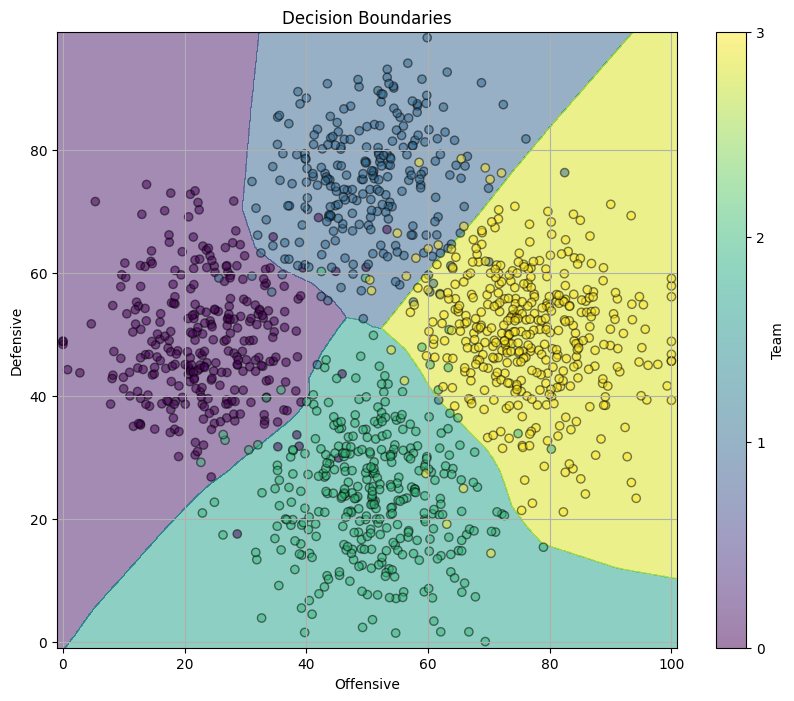

In [94]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy = torch.meshgrid(
    torch.arange(x_min, x_max, 0.1), torch.arange(y_min, y_max, 0.1)
)

input_data = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)

_, Z = torch.max(modelP2(input_data), 1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5)
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k", alpha=0.5)

cb = plt.colorbar(ticks=np.arange(4), label="Team")
cb.ax.set_yticklabels([0, 1, 2, 3])

plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Decision Boundaries")
plt.grid(True)
plt.show()

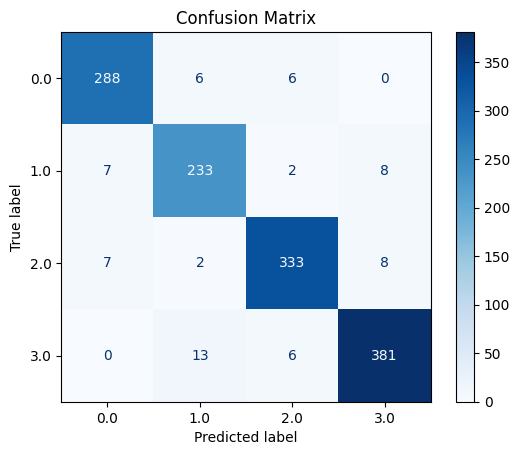

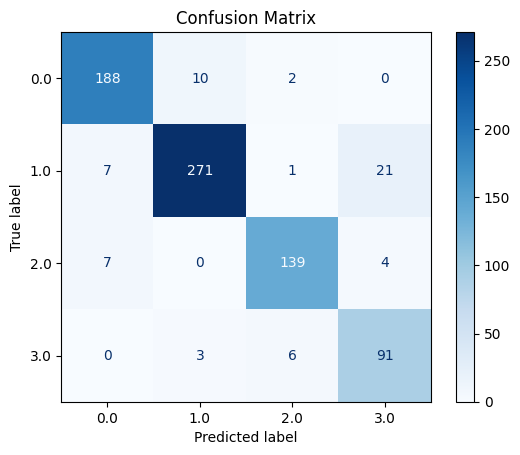

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, predicted), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)

    unique_labels = all_labels.unique().numpy()
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
plot_confusion_matrix(modelP2, train_loader)
plot_confusion_matrix(modelP2, test_loader)